## Modules

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Fonctions

In [2]:
def calculate_age(start):
    
    """ Calcul de l'age du client grace à l'information sur la date de naissance """
    
    start = datetime.datetime.strptime(start, "%d-%m-%Y").date()
    today = datetime.date.today()
    return today.year - start.year - ((today.month, today.day) < (start.month, start.day))

In [3]:
def calculate_life(start):
    
    """Calcul de nombre de mois de survie de chaque clients  """

    REF = datetime.datetime.strptime("28-02-2014", "%d-%m-%Y").date()
    return (REF.year - start.year)*12 - (REF.month < start.month)

In [4]:
def discritiser(x,p,d):
    """
    A function for pareto analyis
    
    Arguments:
    d- dataframe with rfm information
    x- a number (float)
    pq -quantitative columns
        
    Returns:
      an integeer betwen 1 and 4
   """
    if x <= d[p][0.25]:
        return "1"
    elif x <= d[p][0.50]:
        return "2"
    elif x <= d[p][0.75]: 
        return "3"
    else:
        return "4"

## Load Data

In [5]:
sales_df = pd.read_pickle('intermed/sales')
sales_df['tran_date'] = pd.to_datetime(sales_df["tran_date"].str.replace('/','-'), format = '%d-%m-%Y')
sales_df = sales_df.sort_values(by=['customer_Id','tran_date'])

# supprimer des lignes avec des prix negatifs
sales_df= sales_df[sales_df ['Qty'] >= 0]
sales_df = sales_df[sales_df['total_amt'] > 0]

sales_df.head()

,customer_Id,DOB,Gender,city_code,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type
4197,266783,01-05-1974,M,4.0,2,Footwear,1,Mens,25890929042,266783,2011-09-23,1,4,1321,554.820,5838.820,e-Shop
4195,266783,01-05-1974,M,4.0,1,Clothing,4,Mens,98477711300,266783,2012-10-21,4,3,93,29.295,308.295,TeleShop
4198,266783,01-05-1974,M,4.0,5,Books,10,Non-Fiction,16999552161,266783,2013-02-09,10,2,835,175.350,1845.350,e-Shop
4194,266783,01-05-1974,M,4.0,1,Clothing,4,Mens,8410316370,266783,2013-02-20,4,1,869,91.245,960.245,e-Shop
21925,266784,13-12-1991,F,10.0,5,Books,10,Non-Fiction,54234600611,266784,2012-08-23,10,3,1291,406.665,4279.665,TeleShop


In [6]:
sales_df['tran_date'].max()

Timestamp('2014-02-20 00:00:00')

In [7]:
rfm = pd.read_pickle('intermed/rfm.sav')

**frequency** représente le nombre d' achats répétés que le client a effectués. Cela signifie que c'est un de moins que le nombre total d'achats.

**T** représente l'âge du client dans les unités de temps choisies. Celle-ci est égale à la durée entre le premier achat d'un client et la fin de la période étudiée.

## Featues engineeing

### Dummify prod cat

In [8]:
sales_df.groupby('customer_Id').\
    agg({
        "total_amt": "mean",
        "prod_cat": lambda x: ','.join(set(x))
    })

,total_amt,prod_cat
customer_Id,,
266783,2238.177500,"Footwear,Books,Clothing"
266784,1898.021667,"Books,Electronics"
266785,4063.242857,"Footwear,Books,Home and kitchen,Bags"
266788,1523.242500,"Footwear,Books,Bags"
266794,2556.166364,"Clothing,Bags,Books,Footwear,Electronics"
...,...,...
275257,3431.301250,"Footwear,Books,Electronics,Home and kitchen"
275261,1235.021667,"Bags,Books"
275262,2539.290000,"Electronics,Clothing"


In [9]:
# Hhere tran_date  is the  date of last transaction

colonnes_max = ['DOB','Gender', 'tran_date', 'category_Bags', 'category_Books', 'category_Clothing', 'category_Electronics', 'category_Footwear', 'category_Home and kitchen']
# aggregation with max. Foe example :tran_date  is the  date of last transaction

# prémière date de transaction
transaction_min = sales_df.groupby('customer_Id').agg({'tran_date':'min'}).reset_index().rename(columns={'tran_date':'min_tran_date'})

# aggregation
sales_full = sales_df.join(pd.get_dummies(sales_df.prod_cat, prefix='category').astype(int)).\
    groupby('customer_Id').\
    max()[colonnes_max].\
    reset_index().\
    merge(rfm, on='customer_Id').\
    merge(transaction_min, on='customer_Id')

# ages calculaton
sales_full['age'] = sales_full['DOB'].apply(calculate_age)    
sales_full['T_month'] = round((sales_full['T']/30)).astype(int)

In [10]:
sales_full

,customer_Id,DOB,Gender,tran_date,category_Bags,category_Books,category_Clothing,category_Electronics,category_Footwear,category_Home and kitchen,...,R,F,M,RFM_Segment,RFM_Score,Segment,Score,min_tran_date,age,T_month
0,266783,01-05-1974,M,2013-02-20,0,1,1,0,1,0,...,2,2,1,2.02.01.0,5,Hibernating,Green,2011-09-23,47,29
1,266784,13-12-1991,F,2012-12-04,0,1,0,1,0,0,...,1,2,1,1.02.01.0,4,Hibernating,Green,2012-08-23,30,18
2,266785,29-06-1985,F,2013-08-01,1,1,0,0,1,1,...,4,4,4,4.04.04.0,12,Champions,Platinum,2011-03-15,36,36
3,266788,20-03-1972,F,2013-02-12,1,1,0,0,1,0,...,2,2,2,2.02.02.0,6,Hibernating,Bronze,2011-06-12,49,33
4,266794,28-02-1971,F,2014-02-12,1,1,1,1,1,0,...,4,4,3,4.04.03.0,11,Champions,Platinum,2011-03-18,50,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,25-10-1987,M,2013-09-02,0,1,0,1,1,1,...,3,2,4,3.02.04.0,9,Potential loyalists,Silver,2011-12-05,34,27
5502,275261,21-03-1973,F,2013-10-05,1,1,0,0,0,0,...,3,2,2,3.02.02.0,7,Potential loyalists,Bronze,2011-09-26,48,29
5503,275262,06-06-1973,M,2012-02-29,0,0,1,1,0,0,...,1,1,4,1.01.04.0,6,Hibernating,Bronze,2011-08-13,48,31
5504,275264,24-10-1991,M,2011-10-08,0,1,0,0,0,1,...,1,1,3,1.01.03.0,5,Hibernating,Green,2011-08-05,30,31


### Déduire la variable attrition

In [11]:
sales_df.tran_date=sales_df.tran_date.astype(str)

df_transaction = pd.read_csv('input/Transactions.csv', low_memory=False)
# Selection des clients ayant commander aux moins deux fois
temp = df_transaction.groupby(['cust_id']).\
    count()['transaction_id'].\
    reset_index()
temp = temp[temp.transaction_id > 1].drop('transaction_id', axis=1)

# fustionner avec la table principales
temp = pd.merge(temp, sales_df.drop('cust_id',axis=1),  left_on='cust_id',right_on='customer_Id', how='left')

temp.tran_date = temp.tran_date.astype(str).replace('/','-')                  # !!! tran_date is already is format date, So, I shall convert it to string
temp


,cust_id,customer_Id,DOB,Gender,city_code,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type
0,266783,266783,01-05-1974,M,4.0,2,Footwear,1,Mens,25890929042,2011-09-23,1,4,1321,554.820,5838.820,e-Shop
1,266783,266783,01-05-1974,M,4.0,1,Clothing,4,Mens,98477711300,2012-10-21,4,3,93,29.295,308.295,TeleShop
2,266783,266783,01-05-1974,M,4.0,5,Books,10,Non-Fiction,16999552161,2013-02-09,10,2,835,175.350,1845.350,e-Shop
3,266783,266783,01-05-1974,M,4.0,1,Clothing,4,Mens,8410316370,2013-02-20,4,1,869,91.245,960.245,e-Shop
4,266784,266784,13-12-1991,F,10.0,5,Books,10,Non-Fiction,54234600611,2012-08-23,10,3,1291,406.665,4279.665,TeleShop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20408,275264,275264,24-10-1991,M,4.0,5,Books,10,Non-Fiction,94712826085,2011-08-05,10,5,221,116.025,1221.025,TeleShop
20409,275264,275264,24-10-1991,M,4.0,6,Home and kitchen,12,Tools,81382444243,2011-10-08,12,4,587,246.540,2594.540,e-Shop
20410,275265,275265,01-01-1990,M,3.0,4,Bags,1,Mens,7214136016,2011-12-17,1,1,222,23.310,245.310,TeleShop
20411,275265,275265,01-01-1990,M,3.0,5,Books,12,Academic,38961184788,2011-12-26,12,3,188,59.220,623.220,e-Shop


In [12]:
transaction_customer = temp.groupby('customer_Id').\
                        agg({
                            "tran_date": lambda x: ','.join(sorted(set(x)))
                            })

In [13]:
DF=transaction_customer['tran_date'].str.split(',',expand=True)
DF.columns= ["date" + str(i) for i in range(0,11)]
DF

,date0,date1,date2,date3,date4,date5,date6,date7,date8,date9,date10
customer_Id,,,,,,,,,,,
266783,2011-09-23,2012-10-21,2013-02-09,2013-02-20,None,None,None,None,None,None,None
266784,2012-08-23,2012-09-09,2012-12-04,None,None,None,None,None,None,None,None
266785,2011-03-15,2011-10-24,2012-02-01,2012-05-23,2012-07-01,2013-02-13,2013-08-01,None,None,None,None
266788,2011-06-12,2011-09-13,2012-10-31,2013-02-12,None,None,None,None,None,None,None
266794,2011-03-18,2011-04-13,2011-04-22,2011-06-10,2012-01-30,2012-06-28,2012-09-11,2012-11-27,2013-06-29,2014-02-12,None
...,...,...,...,...,...,...,...,...,...,...,...
275257,2011-12-05,2012-09-06,2013-02-26,2013-09-02,None,None,None,None,None,None,None
275261,2011-09-26,2013-06-27,2013-10-05,None,None,None,None,None,None,None,None
275262,2011-08-13,2012-02-29,None,None,None,None,None,None,None,None,None


Text(0.5, 1.0, 'Distribution de durée entre la prémière transaction et la séconde')

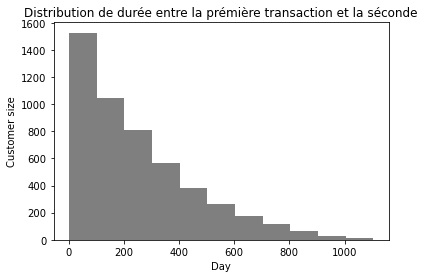

In [14]:
# les deux prémières dates
DF['date0']=pd.to_datetime(DF["date0"], format = '%Y-%m-%d')
DF['date1']=pd.to_datetime(DF["date1"], format = '%Y-%m-%d')

# durée ecoulée
DF['delay']=(DF["date1"]- DF["date0"]).dt.days


# graphiques
plt.hist(DF['delay'],bins=11,facecolor='black', alpha=0.5)
plt.xlabel('Day')
plt.ylabel('Customer size')
plt.title("Distribution de durée entre la prémière transaction et la séconde")

In [15]:
DF['delay'].mean()

249.01502102944121

In [16]:
DF['delay'].quantile([.2, .25, .4, .5, .6, .75, .8, .9])

0.20     64.4
0.25     81.0
0.40    141.0
0.50    194.0
0.60    251.0
0.75    365.0
0.80    415.0
0.90    559.0
Name: delay, dtype: float64

Considerer comme un cas d'attrition y=1

+  tous les clients qui n'ont fait qu'une seule commande  et dont leur dernière achat est inferieur à une année et septembre  2012 
+  tous les clients ayant effectuer au moins deux achats mais qui n'ont pas achété depuis **une année**

In [17]:
#conditions d'attritions
condition = ( sales_full.tran_date <= '01-02-2013')
#création de la variable attrition
sales_full['attrition'] = np.where(condition  , 1 , 0)

# difference between last transaction between and end of peridods for those that have gone
# So reduce there life with temp and add  one year (6 month) (based on the insights we got from the data

temp = (pd.to_datetime(sales_full['tran_date'].max(), format = '%Y-%m-%d') - sales_full['tran_date']) / np.timedelta64(1, 'D')    

sales_full['life'] = np.where(sales_full['attrition'] == 1 , 
                                       (round( (sales_full['T'] -(temp)) /30 ) + 6).astype(int),
                                       (round(sales_full['T']/30)).astype(int)
                             )

sales_full['attrition'].value_counts()

0    4213
1    1293
Name: attrition, dtype: int64

In [18]:
sales_full

,customer_Id,DOB,Gender,tran_date,category_Bags,category_Books,category_Clothing,category_Electronics,category_Footwear,category_Home and kitchen,...,M,RFM_Segment,RFM_Score,Segment,Score,min_tran_date,age,T_month,attrition,life
0,266783,01-05-1974,M,2013-02-20,0,1,1,0,1,0,...,1,2.02.01.0,5,Hibernating,Green,2011-09-23,47,29,0,29
1,266784,13-12-1991,F,2012-12-04,0,1,0,1,0,0,...,1,1.02.01.0,4,Hibernating,Green,2012-08-23,30,18,1,9
2,266785,29-06-1985,F,2013-08-01,1,1,0,0,1,1,...,4,4.04.04.0,12,Champions,Platinum,2011-03-15,36,36,0,36
3,266788,20-03-1972,F,2013-02-12,1,1,0,0,1,0,...,2,2.02.02.0,6,Hibernating,Bronze,2011-06-12,49,33,0,33
4,266794,28-02-1971,F,2014-02-12,1,1,1,1,1,0,...,3,4.04.03.0,11,Champions,Platinum,2011-03-18,50,36,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,25-10-1987,M,2013-09-02,0,1,0,1,1,1,...,4,3.02.04.0,9,Potential loyalists,Silver,2011-12-05,34,27,0,27
5502,275261,21-03-1973,F,2013-10-05,1,1,0,0,0,0,...,2,3.02.02.0,7,Potential loyalists,Bronze,2011-09-26,48,29,0,29
5503,275262,06-06-1973,M,2012-02-29,0,0,1,1,0,0,...,4,1.01.04.0,6,Hibernating,Bronze,2011-08-13,48,31,1,13
5504,275264,24-10-1991,M,2011-10-08,0,1,0,0,0,1,...,3,1.01.03.0,5,Hibernating,Green,2011-08-05,30,31,1,8


## Export Data

In [19]:
sales_full.drop(
                ['DOB','tran_date','F','R','M','T','Score','monetary_value','Segment','min_tran_date','Segment','RFM_Segment'],
                axis=1,
                 inplace=True
                )

# transform to binary feature
sales_full['Gender'] = np.where(sales_full.Gender=='M'  , 1 , 0)

# groupes d ages
quantiles = sales_full.quantile(q=[0.25,0.5,0.75])
sales_full['age_group'] = sales_full['age'].apply(discritiser, args= ('age',quantiles))

# dumify les groupes d'ages
sales_full=pd.get_dummies(sales_full, prefix='age')
for col in sales_full.columns[sales_full.columns.str.startswith('age_')] :
    sales_full[col]=    sales_full[col].astype(int)
    
# gender to binary
sales_full.to_pickle('intermed/table_fo_lifetime.sav')